In [ ]:
#TOOLS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.net("darkgrid")

In [7]:
#read dataset
data = pd.read_csv("Breast_cancer_data.csv")
data.head(10)

FileNotFoundError: ignored

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#bar chart
data["diagnosis"].hist()

<AxesSubplot:>

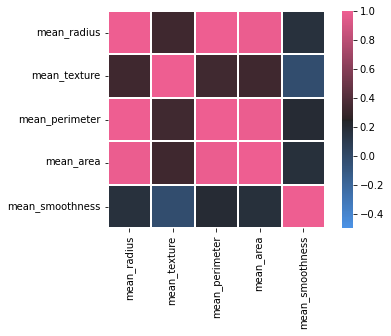

In [ ]:
#confusion matrix
corr = data.iloc[:,:-1].corr(method="pearson")
cmap = sns.diverging_palette(250,354,80,60,center='dark',as_cmap=True)
sns.heatmap(corr, vmax=1, vmin=-.5, cmap=cmap, square=True, linewidths=.2)

<AxesSubplot:xlabel='mean_texture', ylabel='Count'>

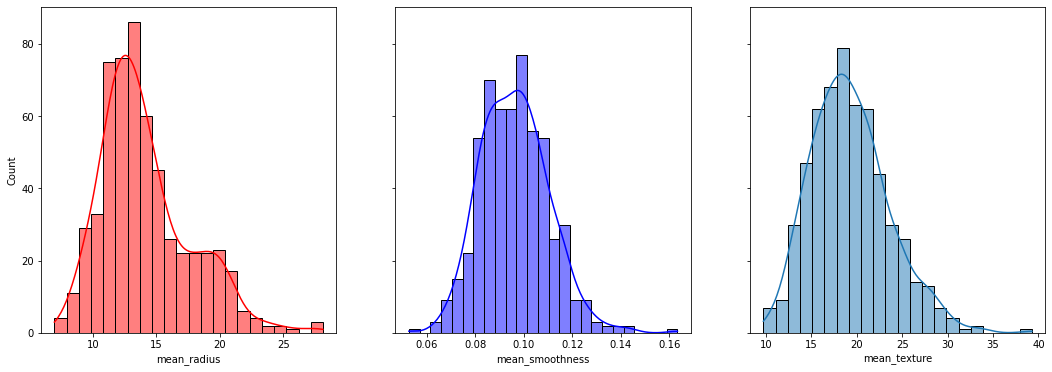

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
sns.histplot(data, ax=axes[0], x="mean_radius", kde=True, color='r')
sns.histplot(data, ax=axes[1], x="mean_smoothness", kde=True, color='b')
sns.histplot(data, ax=axes[2], x="mean_texture", kde=True)

In [ ]:
#Calculate P(Y=y) for all possible y
def calculate_prior(df, Y):
    classes = sorted(list(df[Y].unique()))
    prior = []
    for i in classes:
        prior.append(len(df[df[Y]==i])/len(df))
    return prior

In [ ]:
#Approach 1: Calculate P(X=x|Y=y) using Gaussian distribution
def calculate_likelihood_gaussian(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    mean, std = df[feat_name].mean(), df[feat_name].std()
    p_x_given_y = (1 / (np.sqrt(2 * np.pi) * std)) *  np.exp(-((feat_val-mean)**2 / (2 * std**2 )))
    return p_x_given_y

In [ ]:
#Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum
def naive_bayes_gaussian(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_gaussian(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

In [ ]:
#Test Gaussian model
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_gaussian(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[36  4]
 [ 2 72]]
0.9599999999999999


In [ ]:
#Convert continuous features to Categorical features
data["cat_mean_radius"] = pd.cut(data["mean_radius"].values, bins = 3, labels = [0,1,2])
data["cat_mean_texture"] = pd.cut(data["mean_texture"].values, bins = 3, labels = [0,1,2])
data["cat_mean_smoothness"] = pd.cut(data["mean_smoothness"].values, bins = 3, labels = [0,1,2])

data = data.drop(columns=["mean_radius", "mean_texture", "mean_smoothness"])
data = data[["cat_mean_radius",	"cat_mean_texture",	"cat_mean_smoothness", "diagnosis"]]
data.head(10)

,cat_mean_radius,cat_mean_texture,cat_mean_smoothness,diagnosis
0,1,0,1,0
1,1,0,0,0
2,1,1,1,0
3,0,1,2,0
4,1,0,1,0
5,0,0,2,0
6,1,1,1,0
7,0,1,1,0
8,0,1,2,0
9,0,1,1,0


In [ ]:
#Approach 2: Calculate P(X=x|Y=y) categorically
def calculate_likelihood_categorical(df, feat_name, feat_val, Y, label):
    feat = list(df.columns)
    df = df[df[Y]==label]
    p_x_given_y = len(df[df[feat_name]==feat_val]) / len(df)
    return p_x_given_y

In [ ]:
#Calculate P(X=x1|Y=y)P(X=x2|Y=y)...P(X=xn|Y=y) * P(Y=y) for all y and find the maximum
def naive_bayes_categorical(df, X, Y):
    # get feature names
    features = list(df.columns)[:-1]

    # calculate prior
    prior = calculate_prior(df, Y)

    Y_pred = []
    # loop over every data sample
    for x in X:
        # calculate likelihood
        labels = sorted(list(df[Y].unique()))
        likelihood = [1]*len(labels)
        for j in range(len(labels)):
            for i in range(len(features)):
                likelihood[j] *= calculate_likelihood_categorical(df, features[i], x[i], Y, labels[j])

        # calculate posterior probability (numerator only)
        post_prob = [1]*len(labels)
        for j in range(len(labels)):
            post_prob[j] = likelihood[j] * prior[j]

        Y_pred.append(np.argmax(post_prob))

    return np.array(Y_pred)

In [ ]:
#Test Categorical model
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=.2, random_state=41)

X_test = test.iloc[:,:-1].values
Y_test = test.iloc[:,-1].values
Y_pred = naive_bayes_categorical(train, X=X_test, Y="diagnosis")

from sklearn.metrics import confusion_matrix, f1_score
print(confusion_matrix(Y_test, Y_pred))
print(f1_score(Y_test, Y_pred))

[[38  2]
 [ 5 69]]
0.9517241379310345
